In this script, image tiles are opened, cut into patches and normalized. Normalization has two steps:
1. data^0.2
2. MinMaxScaler fitted on high resolution data


In [1]:
#Authenticate to GEE and GCP, install packages
!pip install --upgrade google-api-python-client   #install Python API
!python -c "from oauth2client import crypt"
!pip install --upgrade earthengine-api==0.1.230
!pip install gcsfs

Requirement already up-to-date: google-api-python-client in /opt/conda/lib/python3.7/site-packages (1.12.8)
Requirement already up-to-date: earthengine-api==0.1.230 in /opt/conda/lib/python3.7/site-packages (0.1.230)


In [2]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import ee
import pandas as pd
import IPython.display as display

Define bucket and filenames, load high resolution images

In [3]:
available = !gsutil ls -r 'gs://era-ml-upressing/*/*.gz';  #find all documents in bucket that begin with gs://era-ml-upressing/ and end with .gz

Selection data:
cell 4 for validation years (used for as input for hydrological model)
cell 5 for test and training data

In [4]:
import re
from sklearn.utils import shuffle
import pandas as pd
years=['1980','1981','1990','1991','2000','2001','2002']
era20_re = re.compile(r'gs://.*ERA20C.*\/(?P<date>\d+)-(?P<scale>\d+km).*')
era5_re = re.compile(r'gs://.*ERA5.*\/(?P<date>\d+)-(?P<scale>\d+km).*')
era20_files = []
for f in available:
  match = era20_re.search(f)    #find all era20 files and save the dates and scale
  if not match:
    continue
  record = match.groupdict()    #dictionary with the dates and scale of file
  record['path'] = f   #add path to dictionary
  if any(record['date'] in d for d in era20_files):
    continue
  elif any(record['date'][:4] in y for y in years):
    era20_files.append(record)
  else:
    continue      #make list of all files and variables (dates and scale)   
era5_files = []
for f in available:
  match = era5_re.search(f)       
  if not match:
    continue
  record = match.groupdict()
  record['path'] = f
  if any(record['date'] in d for d in era5_files):
    continue
  elif any(record['date'][:4] in y for y in years):
    continue
  era5_files.append(record)
era20_df = pd.DataFrame(era20_files) #show table with path, date, scale
era5_df = pd.DataFrame(era5_files)
pairs_df = pd.merge(era20_df, era5_df, left_on='date', right_on='date', suffixes=['_era20c', '_era5'])  #couple files with same date
pairs_df = shuffle(pairs_df)

In [5]:
import re
from sklearn.utils import shuffle
import pandas as pd
years=['1980','1981','1990','1991','2000','2001','2002']
era20_re = re.compile(r'gs://.*ERA20C.*\/(?P<date>\d+)-(?P<scale>\d+km).*')
era5_re = re.compile(r'gs://.*ERA5.*\/(?P<date>\d+)-(?P<scale>\d+km).*')
era20_files = []
for f in available:
  match = era20_re.search(f)    #find all era20 files and save the dates and scale
  if not match:
    continue
  record = match.groupdict()    #dictionary with the dates and scale of file
  record['path'] = f   #add path to dictionary
  if any(record['date'] in d for d in era20_files):
    continue
  elif any(record['date'][:4] in y for y in years):
    continue
  era20_files.append(record)      #make list of all files and variables (dates and scale)   
era5_files = []
for f in available:
  match = era5_re.search(f)       
  if not match:
    continue
  record = match.groupdict()
  record['path'] = f
  if any(record['date'] in d for d in era5_files):
    continue
  elif any(record['date'][:4] in y for y in years):
    continue
  era5_files.append(record)
era20_df = pd.DataFrame(era20_files) #show table with path, date, scale
era5_df = pd.DataFrame(era5_files)
pairs_df = pd.merge(era20_df, era5_df, left_on='date', right_on='date', suffixes=['_era20c', '_era5'])  #couple files with same date
pairs_df = shuffle(pairs_df)

In [6]:
!pip install gcsfs
Username = 'avelon98'
Bucket = 'gs://era-ml-upressing/*/'
filenames_low=list(pairs_df['path_era20c'])
filenames_high=list(pairs_df['path_era5'])
lowResImages = tf.data.TFRecordDataset(filenames_low, compression_type='GZIP')
highResImages = tf.data.TFRecordDataset(filenames_high, compression_type='GZIP')

In [7]:
#parse image tiles, needed when opening TFRecord files. From byte-> float and to have image with right dimensions
def parse_example_high(raw_example):
  shape = [512,512,1]
  featuresDict={'total_precipitation': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32),}
  example = tf.io.parse_single_example(raw_example, featuresDict)
  return example['total_precipitation']
  
def parse_example_low(raw_example):
  shape = [128,128,1]
  featuresDict={'b1': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32),}
  example = tf.io.parse_single_example(raw_example, featuresDict)
  return example['b1']

highResImagePatches = highResImages.map(parse_example_high)
lowResImagePatches = lowResImages.map(parse_example_low)

In [ ]:
#check data distribution
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10, 25))
for ax, example in zip(axes.flat, lowResImagePatches):
  ax.hist(np.ndarray.flatten(example.numpy()), bins=10, range=[0,0.05])

In [ ]:
#cutting out patch middle tiles of non-norized tiles, used to fit scaler.
from sklearn import preprocessing
import functools
import itertools
import pickle


def min_max_scaler(image,shape):
    a = image.numpy()
    flat = np.ndarray.flatten(a)
    b = np.where(flat< 1e-4, 0 , flat)
    return b.reshape(shape, shape, 1)

def scaler(patches, shape):
    # loop over patch position
    positions = [
               ['mlm', 'lr'],
               ['mlm', 'lr'],
               ['mlm', 'lr'],
               ['mlm', 'lr'],
               ['mlm'],
               [ 'mr'],
               ['mm', 'mr'],
               ['mm', 'mr'],
               ['mm', 'mr'],
               ['mm']
    ]
    positions = itertools.cycle(positions)
    for position, patch in zip(positions, patches):
        # loop over subpatches
        processed = min_max_scaler(patch, shape)
        padding = shape // 8
        sub_patches = {}
        # ul [0:64, 0:64]
        sub_patches['ul'] = processed[:-padding*4, :-padding*4]
        # mlm [48:112, 32:96]
        sub_patches['mlm'] = processed[padding*3:-padding*1, padding*2:-padding*2]
        # ll [64:128, 0:64]
        sub_patches['mr'] = processed[padding*2:-padding*2, padding*4:]
        # lr [32:96, 64:128]
        sub_patches['lr'] = processed[padding*4:, padding*4:]

        # mm [32:96, 32:96]
        sub_patches['mm'] = processed[padding*2:-padding*2, padding*2:-padding*2]
        for position_i in position:
            yield sub_patches[position_i]
            
patches_low  = tf.data.Dataset.from_generator(functools.partial(scaler, lowResImagePatches), output_types=tf.float32, output_shapes=[64,64,1], args=[128])
patches_high = tf.data.Dataset.from_generator(functools.partial(scaler, highResImagePatches), output_types=tf.float32, output_shapes=[256, 256,1], args=[512])



In [ ]:
#Look at statistics non-rescaled and rescaled data (depends on your patches_low)

max_list=[]
min_list=[]
mean_list=[]
count_zero=[]
test=[]
for example in patches_high.take(50):    #was patches_high
    a = example.numpy()
    b = np.ndarray.flatten(a)
    test.append(b)
    max_list.append(max(b))
    mean_list.append(np.mean(b))
    min_list.append(min(b))
    count_zero.append(len(b) -np.count_nonzero(b))
    


min_list

(array([2.90462642e+00, 0.00000000e+00, 2.41046731e+00, 2.35169081e+00,
        1.44854745e+00, 6.75863486e-01, 1.62487851e-01, 3.82385163e-02,
        7.31506609e-03, 7.62939271e-04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

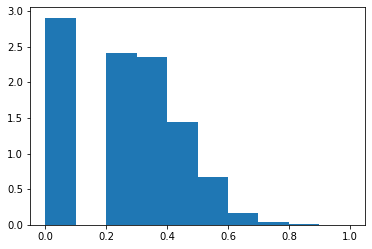

In [ ]:
plt.hist(np.concatenate(test, axis=0 ), density=True)

In [22]:
# fit scaler to high resolution patches, save scaler as 'scaler_new.pkl'
from sklearn import preprocessing
import pickle
scalerfile = 'scaler_new.pkl'
for example in test[:60]:
    a = example.numpy()
    b = np.ndarray.flatten(a)
    listnum.append(b)    
    c = b**(1/5)
    d = c.reshape(-1,1)
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaler.fit(d)
    pickle.dump(scaler, open(scalerfile, 'wb'))
    break

0


Normalilzation data and cutting out patch middle tiles

In [61]:
from sklearn import preprocessing
import functools
import itertools
import pickle


def min_max_scaler(image,shape):
    a = image.numpy()
    flat = np.ndarray.flatten(a)
    b = np.where(flat< 1e-4, 0 , flat)
    c = b**(1/5)
    d = c.reshape(-1,1)  
    scaler = pickle.load(open('scaler_new.pkl', 'rb'))
    e = scaler.transform(d) 
    return e.reshape(shape, shape, 1)

def scaler(patches, shape):
    # loop over patch position
    positions = [
               ['mlm', 'lr'],
               ['mlm', 'lr'],
               ['mlm', 'lr'],
               ['mlm', 'lr'],
               ['mlm'],
               [ 'mr'],
               ['mm', 'mr'],
               ['mm', 'mr'],
               ['mm', 'mr'],
               ['mm']
    ]
    positions = itertools.cycle(positions)
    for position, patch in zip(positions, patches):
        # loop over subpatches
        processed = min_max_scaler(patch, shape)
        padding = shape // 8
        sub_patches = {}
        # ul [0:64, 0:64]
        sub_patches['ul'] = processed[:-padding*4, :-padding*4]
        # mlm [48:112, 32:96]
        sub_patches['mlm'] = processed[padding*3:-padding*1, padding*2:-padding*2]
        # ll [64:128, 0:64]
        sub_patches['mr'] = processed[padding*2:-padding*2, padding*4:]
        # lr [32:96, 64:128]
        sub_patches['lr'] = processed[padding*4:, padding*4:]

        # mm [32:96, 32:96]
        sub_patches['mm'] = processed[padding*2:-padding*2, padding*2:-padding*2]
        for position_i in position:
            yield sub_patches[position_i]
            
patches_low  = tf.data.Dataset.from_generator(functools.partial(scaler, lowResImagePatches), output_types=tf.float32, output_shapes=[64,64,1], args=[128])
patches_high = tf.data.Dataset.from_generator(functools.partial(scaler, highResImagePatches), output_types=tf.float32, output_shapes=[256, 256,1], args=[512])



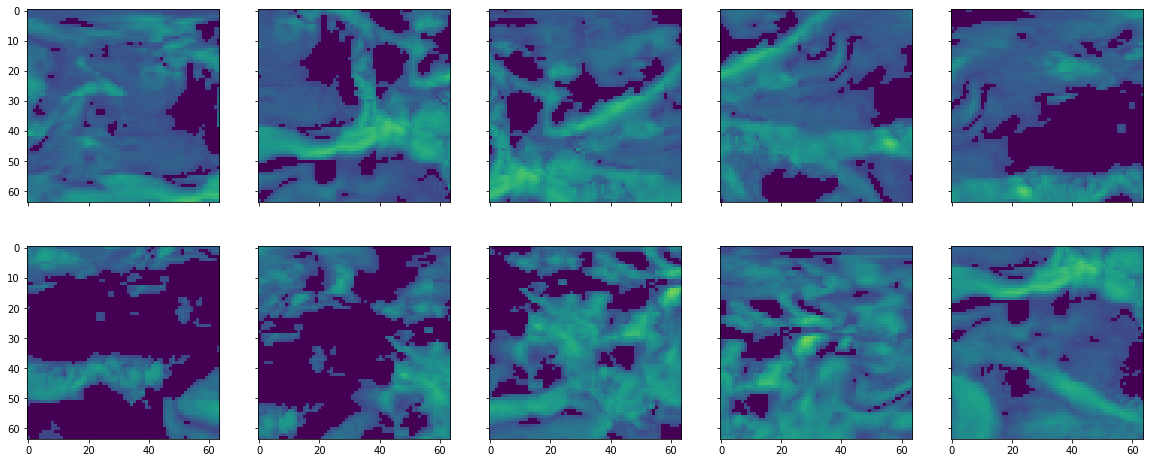

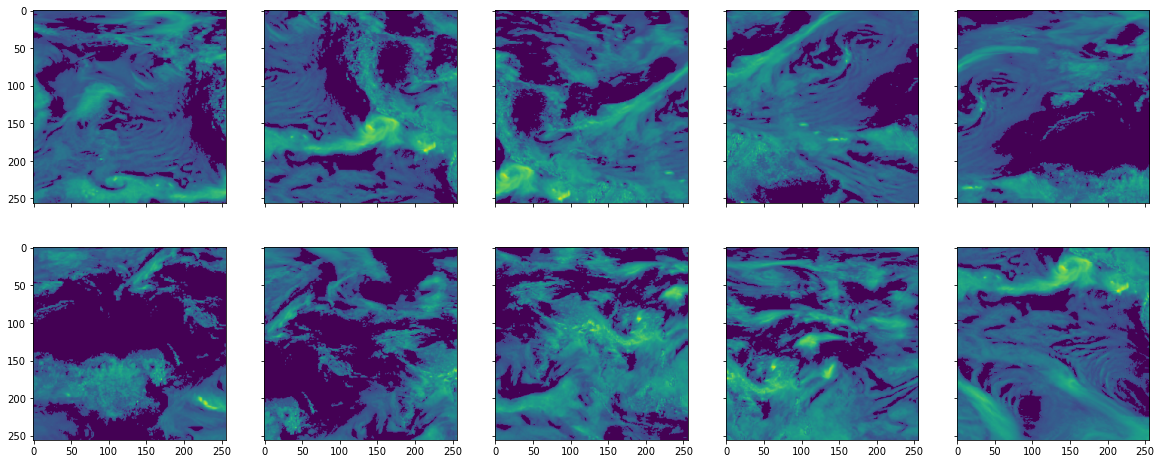

In [62]:
#plot images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(20, 8))
for ax, example in zip(axes.flat, patches_low):
    ax.imshow(example.numpy(), vmin=0, vmax=1)
fig, axes = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(20, 8))
for ax, example in zip(axes.flat, patches_high):
    ax.imshow(example.numpy(), vmin=0, vmax=1)

In [67]:
#serialize tensor, needed to create big TFRecord files
dataset_low = patches_low.map(tf.io.serialize_tensor)
dataset_high= patches_high.map(tf.io.serialize_tensor)

In [70]:
#Save big TFRecord files with batches of image patches in Bucket
import tqdm
for i, batch in tqdm.tqdm(enumerate(dataset_low.batch(8192))):
    filename_low = f'gs://era-ml-upressing/tfrecord_files_L3/Low-{i}'
    writer_low = tf.data.experimental.TFRecordWriter(filename_low, compression_type='GZIP')

 # Converting `batch` back into a `Dataset`, assuming batch is a `tuple` of `tensors`
    batch_ds = tf.data.Dataset.from_tensor_slices(batch)

    writer_low.write(batch_ds)

for i, batch in tqdm.tqdm(enumerate(dataset_high.batch(512))):
    filename_high = f'gs://era-ml-upressing/tfrecord_files_H3/High-{i}'
    writer_high = tf.data.experimental.TFRecordWriter(filename_high, compression_type='GZIP')

 # Converting `batch` back into a `Dataset`, assuming batch is a `tuple` of `tensors`
    batch_ds = tf.data.Dataset.from_tensor_slices(batch)

    writer_high.write(batch_ds)

19it [39:37, 125.15s/it]
298it [5:15:04, 63.44s/it]
